In [49]:
import time
notebook_start_time = time.time()

In [50]:
# from google.colab import files
# uploaded = files.upload()

# Pretrain on Unlabled Data

## Evaluating Generative Text Models

In [51]:
import torch
from ch04 import GPT2Model

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Shortened context length (orig: 1024)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
torch.manual_seed(211)
model = GPT2Model(GPT_CONFIG_124M)
model.eval()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mu

### Create Utility Functions For Text To Token ID Conversion

In [52]:
import tiktoken
from ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text

In [53]:
# example setup
start_context = "In the midst of winter, I found"
bpe_tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model,
                                 input_batch=text_to_token_ids(start_context,
                                                               bpe_tokenizer),
                                 max_new_tokens=10,
                                 context_size=GPT_CONFIG_124M["context_length"]
                                 )

print("output text: \n", token_ids_to_text(token_ids, bpe_tokenizer))

output text: 
 In the midst of winter, I found gluten primarily220 specificity Manufacttions Pictures SiberiaCongress Ess


### Calculate The Text Generation Loss

```
logits -> probabilities -> target probabilities -> log probabilities -> average log probability -> negative average log probability (i.e. cross entropy loss)
```

Let's experiment on a simple example:

In [54]:
# example
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [55]:
# compute logits
with torch.no_grad():
  logits = model(inputs)

# compute probas
probas = torch.softmax(logits, dim=-1)
print("probas shape: ", probas.shape)

# compute argmax and retrieve the token ID with highest probas
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("token IDs shape: ", token_ids.shape)
print("token IDs: \n", token_ids)

# convert token IDs into text
print(f"target batch: {token_ids_to_text(targets[0], bpe_tokenizer)}")
print(f"predicted batch: {token_ids_to_text(token_ids[0].flatten(), bpe_tokenizer)}")

probas shape:  torch.Size([2, 3, 50257])
token IDs shape:  torch.Size([2, 3, 1])
token IDs: 
 tensor([[[26079],
         [46561],
         [31436]],

        [[29764],
         [46155],
         [45644]]])
target batch:  effort moves you
predicted batch: ergy digsCVE


In [56]:
# retrieve target token ID probas for each batch
text_id = 0
target_probas_1 = probas[text_id,
                         [0, 1, 2],
                         targets[text_id]]
print("target probas: ", target_probas_1)

text_id = 1
target_probas_2 = probas[text_id,
                         [0, 1, 2],
                         targets[text_id]]
print("target probas: ", target_probas_2)

target probas:  tensor([5.8695e-06, 1.1964e-05, 2.3211e-05])
target probas:  tensor([1.7885e-05, 1.1387e-05, 1.7034e-05])


In [57]:
# compute log probabilities
log_probas = torch.log(torch.cat([target_probas_1, target_probas_2]))
print("log probas: ", log_probas)

# compute average log probability
avg_log_probas = torch.mean(log_probas)
print("average log probas: ", avg_log_probas)

# compute negative average log probability
neg_avg_log_probas = avg_log_probas * -1
print("negative average log probas: ", neg_avg_log_probas)

log probas:  tensor([-12.0457, -11.3336, -10.6709, -10.9315, -11.3831, -10.9803])
average log probas:  tensor(-11.2242)
negative average log probas:  tensor(11.2242)


Now let's use pytorch `cross_entropy` function:

In [58]:
# example setup
print("logits shape: ", logits.shape)
print("targets shape: ", targets.shape)

# flatten the tensor before plug into cross_entropy
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("flatten logits shape: ", logits_flat.shape)
print("flatten targets shape: ", targets_flat.shape)

# compute loss
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("loss: ", loss)
print("loss as float: ", loss.item())

logits shape:  torch.Size([2, 3, 50257])
targets shape:  torch.Size([2, 3])
flatten logits shape:  torch.Size([6, 50257])
flatten targets shape:  torch.Size([6])
loss:  tensor(11.2242)
loss as float:  11.2241849899292


### Calculating The Training And Validation Set Losses

In [59]:
# setup
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
  text = f.read()

total_characters = len(text)
total_tokens = len(bpe_tokenizer.encode(text))
print(f"total characters: {total_characters}")
print(f"total tokens: {total_tokens}")

total characters: 20479
total tokens: 5145


In [60]:
# train-test split
train_ratio = 0.90
split_id = int(train_ratio * len(text))
train_text = text[:split_id]
val_text = text[split_id:]

In [61]:
# create dataloaders
from ch02 import create_dataloader_V1
torch.manual_seed(211)


train_dataloader = create_dataloader_V1(text=train_text,
                                        batch_size=2,
                                        context_length=GPT_CONFIG_124M["context_length"],
                                        stride=GPT_CONFIG_124M['context_length'],
                                        shuffle=True,
                                        drop_last=True,
                                        num_workers=0)

val_dataloader = create_dataloader_V1(text=val_text,
                                      batch_size=2,
                                      context_length=GPT_CONFIG_124M["context_length"],
                                      stride=GPT_CONFIG_124M['context_length'],
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=0)

In [62]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [63]:
print("train loader:")
for x, y in train_dataloader:
  print(x.shape, y.shape)

print("\nval loader:")
for x, y in val_dataloader:
  print(x.shape, y.shape)

train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

val loader:
torch.Size([2, 256]) torch.Size([2, 256])


Let's create an utility function to calculate the cross entropy loss of a given batch returned via the training and validation loader:

In [64]:
def calc_loss_batch(input_batch,
                    target_batch,
                    model,
                    device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                           target_batch.flatten())
  return loss

Now, we use the above funtion to create a function to compute the training and validation losses:

In [65]:
def calc_loss_loader(dataloader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.
  if len(dataloader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(dataloader)
  else:
    # reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader
    num_batches = min(num_batches, len(dataloader))
  for i, (input_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

Let's compute losses!!!

In [66]:
import time
compute_loss_start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_dataloader,
                                model,
                                device)
  val_loss = calc_loss_loader(val_dataloader,
                              model,
                              device)

print(f"train loss: {train_loss:.4f}")
print(f"validation loss: {val_loss:.4f}")


compute_loss_end_time = time.time()
runtime_in_seconds = compute_loss_end_time - compute_loss_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"compute_loss runtime: {int(minutes)} min {seconds:.2f} sec")

train loss: 10.9759
validation loss: 11.0311
compute_loss runtime: 0 min 0.73 sec


## Training An LLM

Let's implement a training function:

In [67]:
def train_model_simple(model,
                       train_loader,
                       val_loader,
                       optimizer,
                       device,
                       num_epochs,
                       eval_freq,
                       eval_iter,
                       start_context,
                       tokenizer):

  # initialize lists to track losses and tokens seen
  train_losses = []
  val_losses = []
  track_tokens_seen = []
  token_seen = 0
  global_step = -1

  # main training loop - iterate over training epochs
  for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # iterate over batches in each training epoch
    for input_batch, target_batch in train_loader:
      # reset loss gradients from previous batch iteration
      optimizer.zero_grad()

      # calculate loss on current batch
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)

      # backward pass to calculate loss gradients
      loss.backward()

      # update model weights using loss gradients
      optimizer.step()
      token_seen += input_batch.numel()
      global_step += 1

      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print training and evaluation set loss
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # generative sample text for visual inspection
    generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context)

  return train_losses, val_losses, track_tokens_seen


def evaluate_model(model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter):
  # set model to evaluation mode
  model.eval()
  with torch.no_grad():
    # calculate loss
    train_loss = calc_loss_loader(train_loader,
                                  model,
                                  device,
                                  num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,
                                model,
                                device,
                                num_batches=eval_iter)

  # set model bacl to training mode
  model.train()
  return train_loss, val_loss


def generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context):
  # set model to evaluation mode
  model.eval()
  context_size = model.position_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model,
                                     input_batch=encoded,
                                     max_new_tokens=50,
                                     context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " ")) # compact print format
  # set model bacl to training mode
  model.train()

Let's train the LLM:

In [78]:
import time
training_start_time = time.time()

torch.manual_seed(211)
model = GPT2Model(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.0004,
                              weight_decay=0.1)
num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(model=model,
                                                             train_loader=train_dataloader,
                                                             val_loader=val_dataloader,
                                                             optimizer=optimizer,
                                                             device=device,
                                                             num_epochs=num_epochs,
                                                             eval_freq=5,
                                                             eval_iter=5,
                                                             start_context="In the midst of winter, I found",
                                                             tokenizer=bpe_tokenizer)


training_end_time = time.time()
runtime_in_seconds = training_end_time - training_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"device: {device}")
print(f"training runtime: {int(minutes)} min {seconds:.2f} sec")

Ep 1 (Step 000000): Train loss 9.793, Val loss 10.015
Ep 1 (Step 000005): Train loss 8.116, Val loss 8.308
In the midst of winter, I found the                                                 
Ep 2 (Step 000010): Train loss 6.760, Val loss 7.085
Ep 2 (Step 000015): Train loss 6.054, Val loss 6.605
In the midst of winter, I found the, and, and, the, the, and, and, and, the, and, the the the the, the, and the, and, the the the, the the the the, the the the the the, the, the
Ep 3 (Step 000020): Train loss 7.540, Val loss 9.204
Ep 3 (Step 000025): Train loss 5.570, Val loss 6.454
In the midst of winter, I found, and, and I was, and the.                                        
Ep 4 (Step 000030): Train loss 5.501, Val loss 6.621
Ep 4 (Step 000035): Train loss 5.269, Val loss 6.500
In the midst of winter, I found the with the I had I had " had the I had the I had " I had the I had the with the and I had the with the with the with the with the I had the and I had the he was to the with the wit

Let's plot a loss graph:

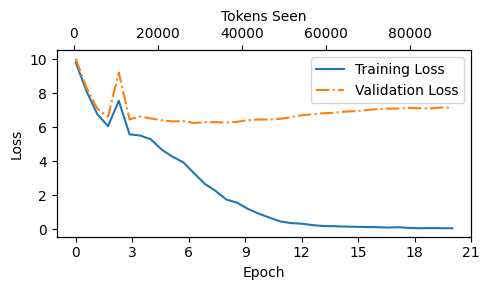

In [79]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epoch_seen,
                tokens_seen,
                train_losses,
                val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  # plot training and validation loss against epochs
  ax1.plot(epoch_seen, train_losses, label="Training Loss")
  ax1.plot(epoch_seen, val_losses, linestyle="-.", label="Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

  # create a second x-axis for token seen
  ax2 = ax1.twiny() # create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
  ax2.set_xlabel("Tokens Seen")

  fig.tight_layout() # asjust layput to make room
  plt.savefig("loss_plot.pdf")
  plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding Strategies To Control Randomness

In [80]:
model.to("cpu")
model.eval()

bpe_tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model,
                                 input_batch=text_to_token_ids("In the midst of winter, I found",
                                                               bpe_tokenizer),
                                 max_new_tokens=20,
                                 context_size=GPT_CONFIG_124M["context_length"]
                                 )

print("output text: \n", token_ids_to_text(token_ids, bpe_tokenizer))

output text: 
 In the midst of winter, I found-stream stroke. Gisburn--as such--had not existed till nearly a year after Jack


### Temperature Scaling

In [81]:
# example setup
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [86]:
torch.manual_seed(211)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [87]:
def print_sampled_tokens(probas):
    torch.manual_seed(211) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

75 x closer
2 x every
0 x effort
568 x forward
3 x inches
2 x moves
0 x pizza
350 x toward
0 x you


In [88]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

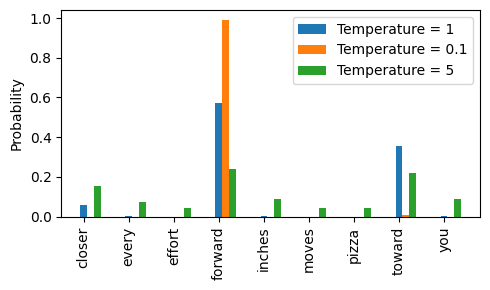

In [89]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [90]:

print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
987 x forward
0 x inches
0 x moves
0 x pizza
13 x toward
0 x you


In [91]:
print_sampled_tokens(scaled_probas[2])

158 x closer
76 x every
42 x effort
243 x forward
86 x inches
52 x moves
40 x pizza
228 x toward
75 x you


### Top-k Sampling

In [93]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [94]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


see https://github.com/rasbt/LLMs-from-scratch/discussions/326

In [95]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Modifying The Text Generation Function

Let's add `temperature sampling` and `top-k` sampling to the `generate_text_simple()` function from `ch04.py`:

In [99]:
def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=-1) # [batch, num_tokens+1]

  return input_batch

In [100]:
# test the function
torch.manual_seed(211)
token_ids = generate_text(model=model,
                          input_batch=text_to_token_ids("In the midst of winter, I found",
                                                        bpe_tokenizer),
                          max_new_tokens=20,
                          context_size=GPT_CONFIG_124M["context_length"],
                          temperature=1.4,
                          top_k=25
                          )

print("output text: \n", token_ids_to_text(token_ids, bpe_tokenizer))

output text: 
 In the midst of winter, I found of the axioms he laid down, tips of a self-confident m past! The


## Load And Save Model Weights In Pytorch

In [101]:
# save model state_dict
torch.save(model.state_dict(), "model.pth")

In [103]:
# load model state_dict
model = GPT2Model(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mu

We can save and load model together with the optimizers' additional parameters:

In [104]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [106]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPT2Model(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mu

In [70]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")

Notebook runtime: 4 min 58.12 sec
